# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:13<00:00, 4.35kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

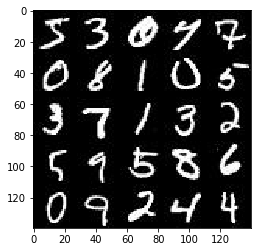

In [8]:
data_dir = './data'
import helper
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

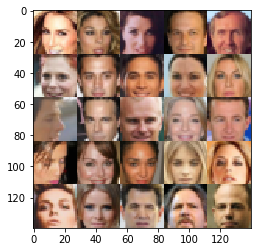

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/teja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:


import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs')
    z = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs, z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
# Our kernel size
kernel_size = 5
# Lazy alpha to softly clip negative values
alpha = 0.2
# Initial convolution depth
initial_conv_depth = 64
# Label smoothing rate
smoothing_rate = 0.1
# Total count of convolution layers
layer_count = 4
# The size of the images to be awaited
image_axis_size = 28


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv_depth = initial_conv_depth
        
        tar_size = image_axis_size//4 # out target image will be 7x7
        
        # Input layer is 28x28xDims
        cur_size = image_axis_size #28
        layer0_conv = tf.layers.conv2d(images, conv_depth, kernel_size, strides=2, padding='same')
        layer0_lazy_relu = tf.maximum(layer0_conv*alpha, layer0_conv)
        cur_layer = layer0_lazy_relu

        # first step without normalization resized it to 14x14x64
        cur_size = cur_size//2
        
        # for all other equal steps attach a set of convolution, normalization and lazy relu
        for index in range(layer_count-1):
            conv_depth *= 2 # convolutional layers always double
            cur_stride = 1 # stride of 1 by default
            
            if cur_size>tar_size: # if we are still allowed to half the size, use a stride of 2
                cur_stride = 2
                cur_size = cur_size//2
            
            cur_layer = tf.layers.conv2d(cur_layer, conv_depth, kernel_size, strides=cur_stride, padding='same')
            cur_layer = tf.layers.batch_normalization(cur_layer, training=True)
            cur_layer = tf.maximum(cur_layer*alpha, cur_layer)

        # flatten the last layer and then fully connect it to a classification boolean discrimanting between real and
        # generated
        flattened = tf.reshape(cur_layer, (-1, tar_size*tar_size*conv_depth))
        logits = tf.layers.dense(flattened, 1)
        # apply sigmoid to get everything into a 0..1 range
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=True if is_train==False else False):
        
        # Definitions        
        init_2d_size = image_axis_size//4
        init_depth = 512
        target_size = image_axis_size # result shall be 28x28 again
        first_conv_layer_size = init_2d_size*init_2d_size*init_depth
        layer0_densed_z = tf.layers.dense(z, first_conv_layer_size)

        cur_depth = init_depth

        # reshape from a one dimensional array of data for the pixels to a 3 dimensional array again
        layer0_reshaped = tf.reshape(layer0_densed_z, (-1,init_2d_size,init_2d_size,init_depth))
        layer0_normalized = tf.layers.batch_normalization(layer0_reshaped, training=is_train)
        layer0_lazy_relu = tf.maximum(layer0_normalized*alpha,layer0_normalized)
        
        # reconstruct the strides of the discrimnator process
        cur_size = image_axis_size
        tar_size = image_axis_size/4
        
        strides = []
        
        for index in range(layer_count):            
            cur_stride = 1
            
            if cur_size>tar_size:
                cur_stride = 2
                cur_size = cur_size//2
                
            strides.append(cur_stride)
            
        # setup the center convolutional layers
        cur_layer = layer0_lazy_relu
        
        for index in range(layer_count-1):    
            cur_depth = cur_depth//2
            cur_stride = strides[len(strides)-1-index]
            cur_layer = tf.layers.conv2d_transpose(cur_layer, cur_depth, kernel_size, strides=cur_stride, padding='same')
            cur_layer = tf.layers.batch_normalization(cur_layer, training=is_train)
            cur_layer = tf.maximum(cur_layer*alpha, cur_layer)

        # Output layer, 28x28xDim again
        logits = tf.layers.conv2d_transpose(cur_layer, out_channel_dim, kernel_size, strides=2, padding='same')
        # now 28x28x3 or 28x28x1 again
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1.0 - smoothing_rate)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # receive all trainable variables
    t_vars = tf.trainable_variables()
    
    # isolate discriminator and generator variables
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # setup adam optimizers for both
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # collect samples and losses for logging purposes
    samples, losses = [], []
    
    # total count of steps done
    steps = 0
    
    # steps at which the current generator state shall be visualized
    log_steps_every = 100
    print_every = 20
    
    channel_count = 3 if data_image_mode=='RGB' else 1
    
    learning_rate_value = learning_rate
    
    # Fetch input image size
    image_width = data_shape[2]
    image_height = data_shape[1]

    # Setup inputs
    input_real, input_z, learning_rate = model_inputs(image_width, image_height, channel_count, z_dim)
    # Setup loss functions
    d_loss, g_loss = model_loss(input_real, input_z, channel_count)
    # Setup optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    
    
    # Start the training 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # increase step counter
                steps += 1
                
                # rescale the images from -0.5 to +0.5 to -1.0 to +1.0
                batch_images *= 2
                
                # create random noise fir the generator with the same sample count as the real image's count
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers each turn - discriminator first - generator second
                _ = sess.run(d_opt, feed_dict={learning_rate: learning_rate_value, input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={learning_rate: learning_rate_value, input_z: batch_z, input_real: batch_images})

                # print losses at the end of each epoch
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({learning_rate: learning_rate_value, input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({learning_rate: learning_rate_value, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                # show the current image status regularly
                if steps%log_steps_every==0:
                    show_generator_output(sess, show_n_images, input_z, channel_count, data_image_mode)
    
        # show the final image status
        show_generator_output(sess, show_n_images, input_z, channel_count, data_image_mode)
    return
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5375... Generator Loss: 2.0686
Epoch 1/2... Discriminator Loss: 5.1604... Generator Loss: 0.0382
Epoch 1/2... Discriminator Loss: 0.9788... Generator Loss: 1.7021
Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 4.5648
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.7608


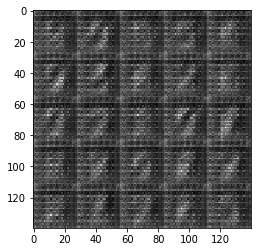

Epoch 1/2... Discriminator Loss: 0.6515... Generator Loss: 2.0356
Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 2.7609
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 2.1210
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 1.8803
Epoch 1/2... Discriminator Loss: 0.7359... Generator Loss: 2.9834


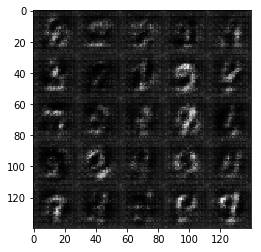

Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 1.0297
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 1.3158
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.1045
Epoch 1/2... Discriminator Loss: 0.8990... Generator Loss: 1.1139
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 3.3742


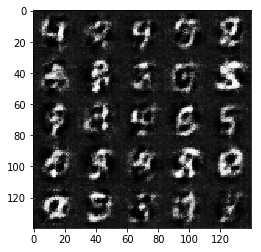

Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 3.4102
Epoch 1/2... Discriminator Loss: 0.6112... Generator Loss: 1.9564
Epoch 1/2... Discriminator Loss: 0.6245... Generator Loss: 2.9934
Epoch 1/2... Discriminator Loss: 0.5188... Generator Loss: 2.4006
Epoch 1/2... Discriminator Loss: 1.5903... Generator Loss: 0.4975


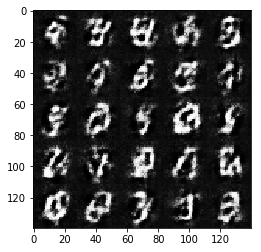

Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 2.8021
Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 1.7537
Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 2.4330
Epoch 1/2... Discriminator Loss: 0.6264... Generator Loss: 2.0062
Epoch 1/2... Discriminator Loss: 0.5608... Generator Loss: 2.8387


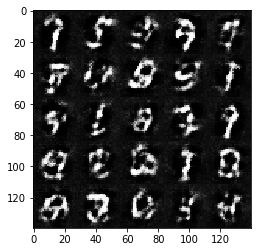

Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 1.5396
Epoch 1/2... Discriminator Loss: 0.5003... Generator Loss: 2.5842
Epoch 1/2... Discriminator Loss: 0.6628... Generator Loss: 1.7181
Epoch 1/2... Discriminator Loss: 0.7609... Generator Loss: 1.3187
Epoch 1/2... Discriminator Loss: 0.5573... Generator Loss: 2.3070


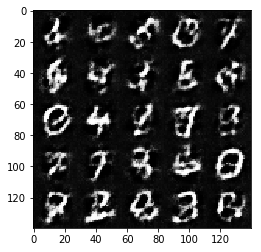

Epoch 1/2... Discriminator Loss: 0.6875... Generator Loss: 2.7436
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 1.3885
Epoch 1/2... Discriminator Loss: 0.8442... Generator Loss: 1.2225
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 0.6386... Generator Loss: 2.2081


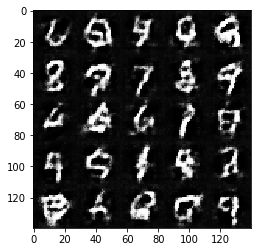

Epoch 1/2... Discriminator Loss: 0.5733... Generator Loss: 2.1940
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 3.8322
Epoch 1/2... Discriminator Loss: 0.8511... Generator Loss: 3.6203
Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.6089


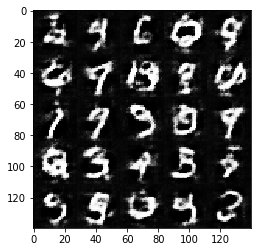

Epoch 1/2... Discriminator Loss: 0.6188... Generator Loss: 1.8069
Epoch 1/2... Discriminator Loss: 0.5433... Generator Loss: 1.9745
Epoch 1/2... Discriminator Loss: 1.6934... Generator Loss: 0.8399
Epoch 1/2... Discriminator Loss: 0.5966... Generator Loss: 2.2116
Epoch 1/2... Discriminator Loss: 0.6757... Generator Loss: 1.5593


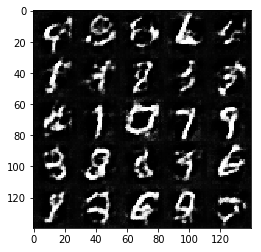

Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 2.2744
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.0477
Epoch 2/2... Discriminator Loss: 0.5648... Generator Loss: 2.0588
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.6445
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 3.5704


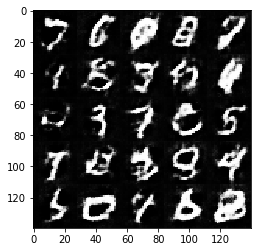

Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.7664
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.4920
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 0.8246
Epoch 2/2... Discriminator Loss: 0.9046... Generator Loss: 1.1490
Epoch 2/2... Discriminator Loss: 0.7806... Generator Loss: 1.2047


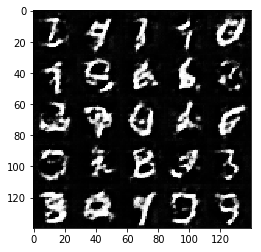

Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 1.4554
Epoch 2/2... Discriminator Loss: 0.7928... Generator Loss: 1.2494
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 1.0273
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.0222


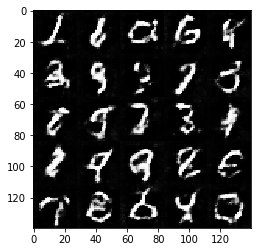

Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 1.3585
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 2.1818... Generator Loss: 4.3989
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.0093
Epoch 2/2... Discriminator Loss: 0.6315... Generator Loss: 1.7543


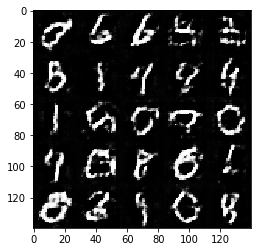

Epoch 2/2... Discriminator Loss: 1.4702... Generator Loss: 2.8610
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 1.6894
Epoch 2/2... Discriminator Loss: 0.8171... Generator Loss: 1.4488
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 2.0461
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 2.3904


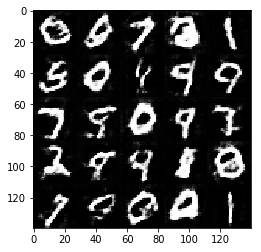

Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.2361
Epoch 2/2... Discriminator Loss: 0.5584... Generator Loss: 1.9797
Epoch 2/2... Discriminator Loss: 0.6798... Generator Loss: 1.4305
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.6790
Epoch 2/2... Discriminator Loss: 0.7739... Generator Loss: 1.2400


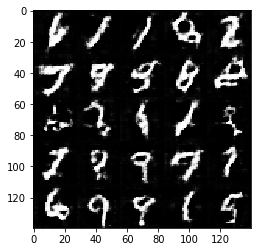

Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 3.8319
Epoch 2/2... Discriminator Loss: 0.6120... Generator Loss: 2.1707
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 2.1021
Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.4547
Epoch 2/2... Discriminator Loss: 0.6084... Generator Loss: 2.0805


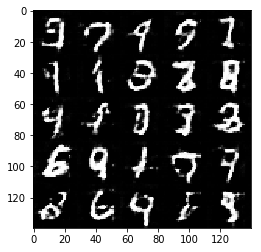

Epoch 2/2... Discriminator Loss: 0.8692... Generator Loss: 3.2753
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 1.4602
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.4277
Epoch 2/2... Discriminator Loss: 2.0543... Generator Loss: 0.4445
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 0.9939


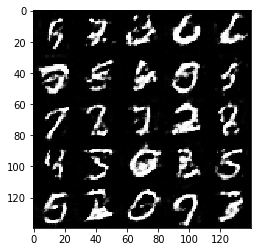

Epoch 2/2... Discriminator Loss: 1.2839... Generator Loss: 0.6649
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.2402
Epoch 2/2... Discriminator Loss: 0.6446... Generator Loss: 1.6631
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 2.4098... Generator Loss: 0.2801


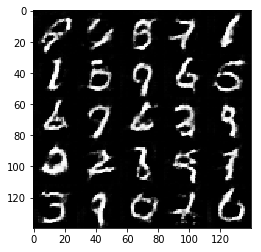

Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 0.5645... Generator Loss: 2.1283


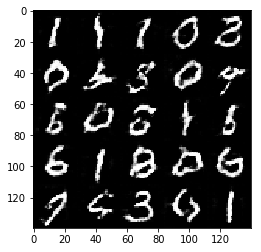

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 4.7876
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.2917
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 3.1025
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 3.2904
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 3.1094


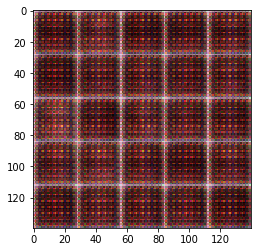

Epoch 1/1... Discriminator Loss: 2.2791... Generator Loss: 0.2658
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.5401
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.0002


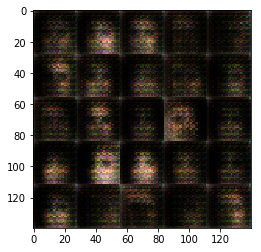

Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.7048
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 6.2247
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.8410


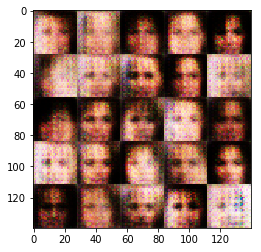

Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 2.6350
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 2.0833
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 4.6168
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 2.4538
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.0559


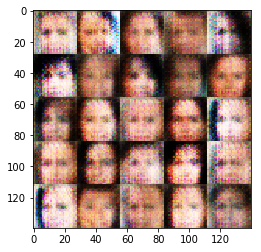

Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.5789
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.4453
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 2.0397
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.2278


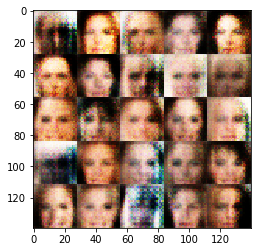

Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.8475
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 2.3145
Epoch 1/1... Discriminator Loss: 1.7120... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 1.2022


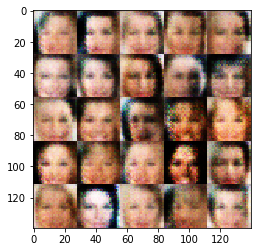

Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 2.2634


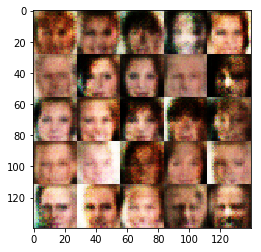

Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.6683... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.1662
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.2994


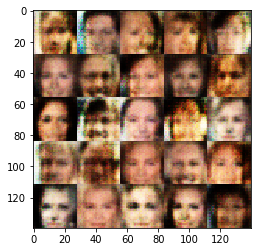

Epoch 1/1... Discriminator Loss: 1.6235... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.8857


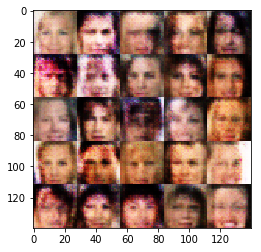

Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.5561
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.6130
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.3451
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 2.3547
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 2.2625


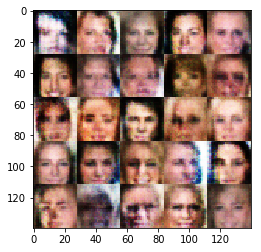

Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 2.1801
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.3613
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.9981
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.1194


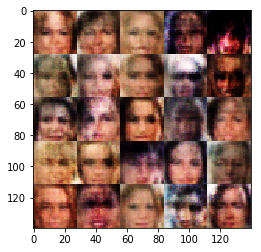

Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.8956
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.3363
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 2.3316


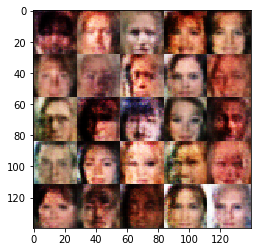

Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 1.7341... Generator Loss: 0.3660
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 2.0310


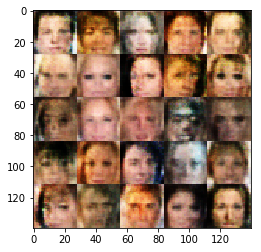

Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 2.6820
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 2.4072
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.7943


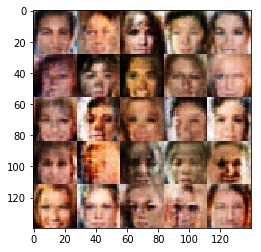

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.7708


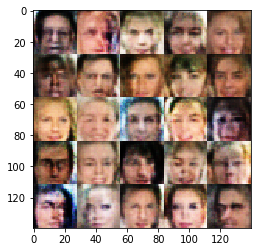

Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 2.6606
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 2.0922


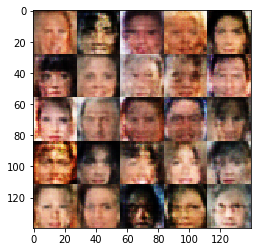

Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.8069


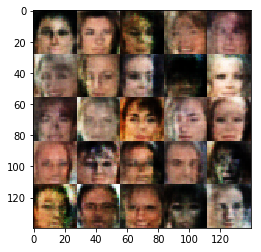

Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 2.7921
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 2.1670
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 2.5957
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.5609


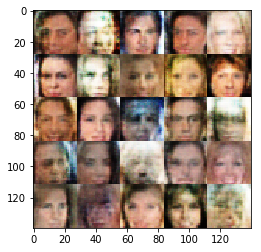

Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.7712
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.1828
Epoch 1/1... Discriminator Loss: 1.7317... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 1.6500... Generator Loss: 3.3302


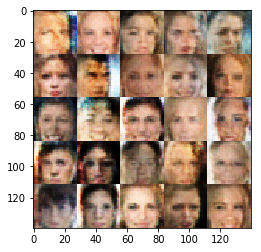

Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.4448
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.5722


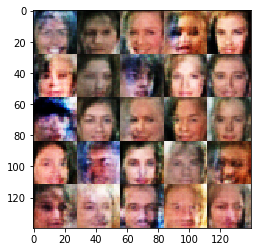

Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.2296
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 0.7492... Generator Loss: 2.2700


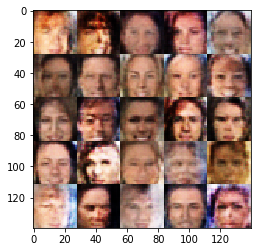

Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.0498... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.1027


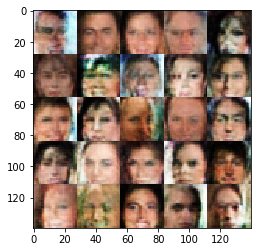

Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 2.5218


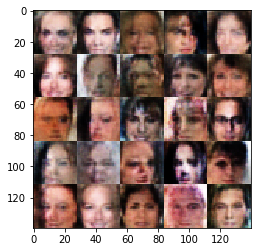

Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.9284
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.4534
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.9423


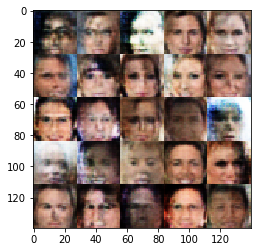

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 2.6506
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6014


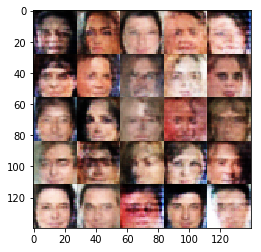

Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.6275
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.5578


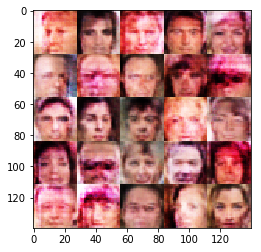

Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.7179
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.9351
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 2.0507
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.2541


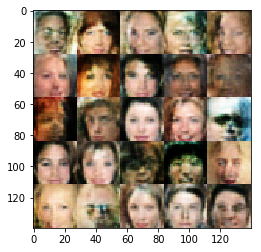

Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 2.0337
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.1734


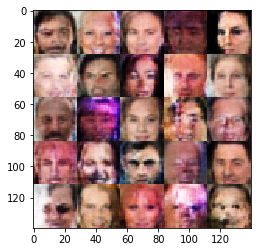

Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 1.5301
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 2.7140
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.5720
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.5996
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.7859


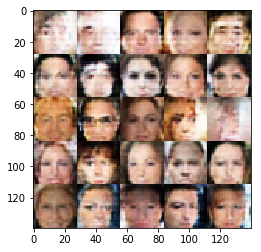

Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 2.4023
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 2.6400
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.6841


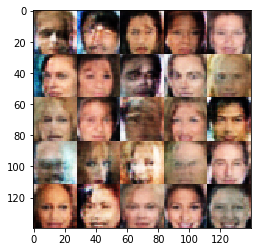

Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 0.8710... Generator Loss: 2.3700
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.7836


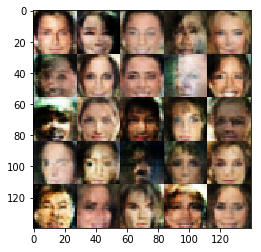

Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.7230
Epoch 1/1... Discriminator Loss: 1.6250... Generator Loss: 0.3840


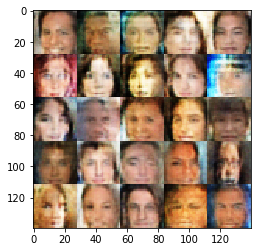

In [19]:

batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.